# Práctica 4 Eigenfaces

**Martínez Ostoa Néstor & Ramírez Bondi J. Alejandro**

Reconocimiento de Patrones

Facultad de Ingeniería

11 de agosto de 2021

## 1. Eigenfaces

In [1]:
import random
import sys
import os
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

Number of loaded images: 3993


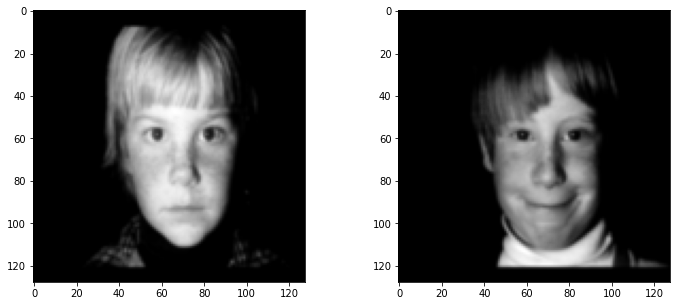

In [2]:
RAW_DATA_PATH = 'rawdata/'
ROWS = 128
COLS = 128


def read_image(img_file):
    file = open(RAW_DATA_PATH + img_file)
    img = np.fromfile(file, dtype=np.uint8, count=ROWS * COLS)
    img.shape = (img.size // COLS, COLS)
    return img


def read_images():
    dir_contents = os.listdir(RAW_DATA_PATH)
    dir_contents = [c for c in dir_contents if c[0] != '.']
    dir_contents = sorted(dir_contents)
    images = []
    for img_name in dir_contents:
        images.append(read_image(img_name))
    return images


def show_images(images):
    fig = plt.figure(figsize=(12, 5))
    rows, cols = 1, len(images)
    for idx, img in enumerate(images):
        fig.add_subplot(rows, cols, idx + 1)
        plt.imshow(img, cmap='gray')
    plt.show()


raw_images = read_images()
print(f'Number of loaded images: {len(raw_images)}')
show_images(raw_images[1:3])

In [3]:
min_rows, min_cols = sys.maxsize, sys.maxsize
max_rows, max_cols = 0, 0
for i, image in enumerate(raw_images):
    r, c = image.shape[0], image.shape[1]
    min_rows = min(min_rows, r)
    max_rows = max(max_rows, r)
    min_cols = min(min_cols, c)
    max_cols = max(max_cols, c)
print(f'\n--> Least common image size: {min_rows} x {min_cols} pixels.')


--> Least common image size: 128 x 128 pixels.


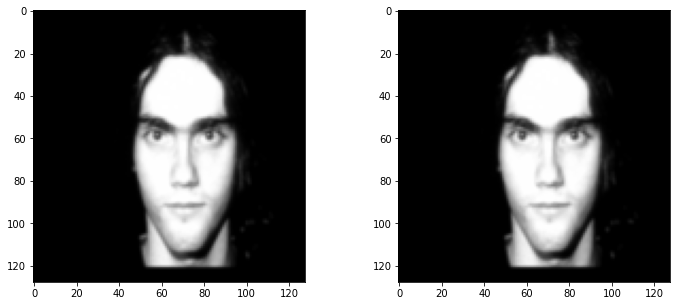

In [4]:
def recenter(image, min_rows, min_cols):
    r, c = image.shape
    top, bot, left, right = 0, r, 0, c
    if r > min_rows:
        top = r - min_rows
    if c > min_cols:
        right = min_cols
    return image[top:bot, left:right]


image_0 = raw_images[999]
image_0_recentered = recenter(image_0, min_rows, min_cols)
show_images([image_0, image_0_recentered])

### Cálculo de rostro promedio

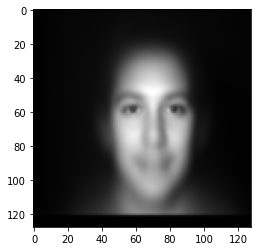

In [6]:
avg_image = np.mean(raw_images, axis=0)
plt.imshow(avg_image, cmap='gray')
plt.show()

### Data Matrix

(3993, 16384)


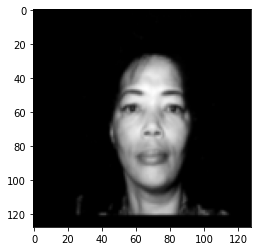

In [7]:
m = len(raw_images)
raw_images_reshape = raw_images
d = min_rows * min_cols
x = np.reshape(raw_images_reshape, (m, d))
print(x.shape)
x_restore = np.reshape(x[int(len(x) / 2), :], (min_rows, min_cols))
plt.imshow(x_restore, cmap='gray')
plt.show()

### PCA

In [8]:
u, sigma, vt = np.linalg.svd(x, full_matrices=False)
print(f'Dimensiones\nX <-- {x.shape}\nU <-- {u.shape}\nSigma <-- {sigma.shape}\nV^T <-- {vt.shape}')

Dimensiones
X <-- (3993, 16384)
U <-- (3993, 3993)
Sigma <-- (3993,)
V^T <-- (3993, 16384)


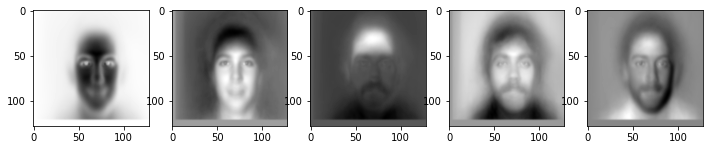

In [9]:
x = np.arange(1, sigma.shape[0])

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x,
    y=sigma[0] / np.sqrt(x),
    name='sigma_0/sqrt(x)'
))
fig.add_trace(go.Scatter(
    x=np.arange(sigma.shape[0]),
    y=sigma,
    mode='markers', name='Singular Values'
))
fig.update_layout(
    template='plotly_white',
    title=dict(
        text='Singular values'
    )
)
fig.show()


def get_n_principal_components(n, vt):
    images = []
    d = int(np.sqrt(vt[0].shape[0]))
    for i in range(n):
        images.append(vt[i].reshape(d, d))
    return images


principal_components = get_n_principal_components(5, vt)
show_images(principal_components)

## 2. Reconstrucción de rostros

***Eigenfaces with PCA***

In [10]:
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

slice_images = True # Determina si se deben cortar las imágenes a 64 x 64
min_faces_per_person = 10
if slice_images:
    faces = fetch_lfw_people(min_faces_per_person=3,
                             slice_=(slice(69, 197), slice(69, 197))).data # 64 x 64: tamaño obtenido de documentación
    face_size = (64, 64)
else:
    faces = fetch_lfw_people(min_faces_per_person=min_faces_per_person).data # Tamaño original <- 62 x 47
    face_size = (62, 47)

print(faces.shape)

(7606, 4096)


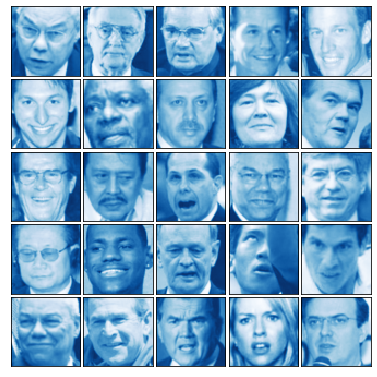

In [11]:
fig = plt.figure(figsize=(5, 5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
j = 1
np.random.seed(413)
for i in np.random.choice(range(faces.shape[0]), 25):
    ax = fig.add_subplot(5, 5, j, xticks=[], yticks=[])
    ax.imshow(np.reshape(faces[i, :], face_size), cmap=plt.cm.Blues_r, interpolation='nearest')
    j += 1
plt.show()

Tamaño de vector de transformación: (7606, 1024)


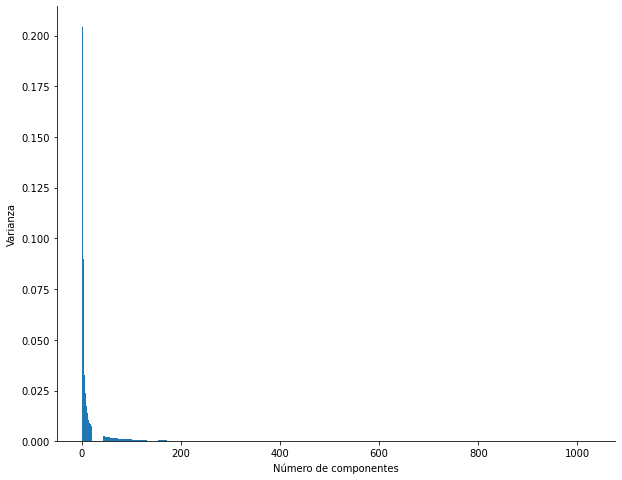

In [12]:
num_components = 1024
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
faces_processing =  pipeline.fit_transform(faces)
print(f'Tamaño de vector de transformación: {faces_processing.shape}')
mean_face = np.reshape(pipeline.named_steps['scaling'].mean_, face_size)
sd_face = np.reshape(pipeline.named_steps['scaling'].var_, face_size)
pca_res = pipeline.named_steps['pca'].explained_variance_ratio_
# Distribución de varianza
_, ax = plt.subplots(figsize=(10, 8))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Número de componentes')
ax.set_ylabel('Varianza')
ax.bar(np.arange(1, pca_res.shape[0] + 1), pca_res)
plt.show()

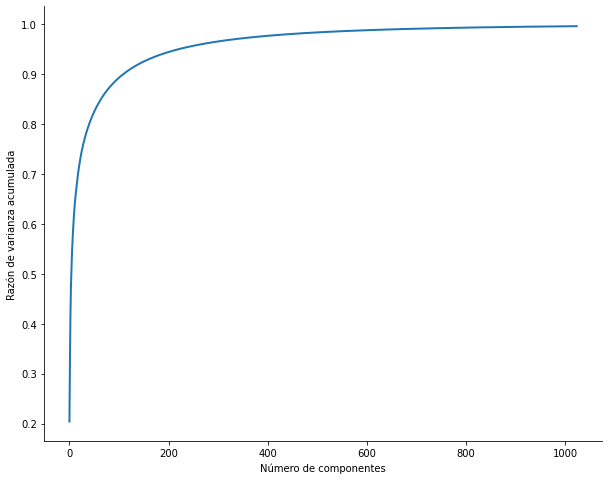

In [13]:
# Razón de varianza acumulada
_, ax = plt.subplots(figsize=(10, 8))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Número de componentes')
ax.set_ylabel('Razón de varianza acumulada')
ax.plot(np.cumsum(pca_res), linewidth=2)
plt.show()

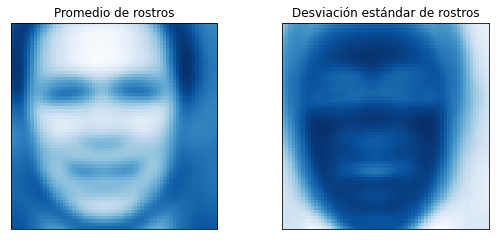

In [14]:
# Obtenemos las caras procesadas
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(left=0, right=3, bottom=0, top=3, hspace=0.05, wspace=0.05)
ax = fig.add_subplot(10, 8, 1, xticks=[], yticks=[])
ax.imshow(mean_face, cmap=plt.cm.Blues_r)
ax.set_title('Promedio de rostros')
ax = fig.add_subplot(10, 8, 2, xticks=[], yticks=[])
ax.imshow(sd_face, cmap=plt.cm.Blues_r)
ax.set_title('Desviación estándar de rostros')
plt.show()

### Visualización de las eigenfaces

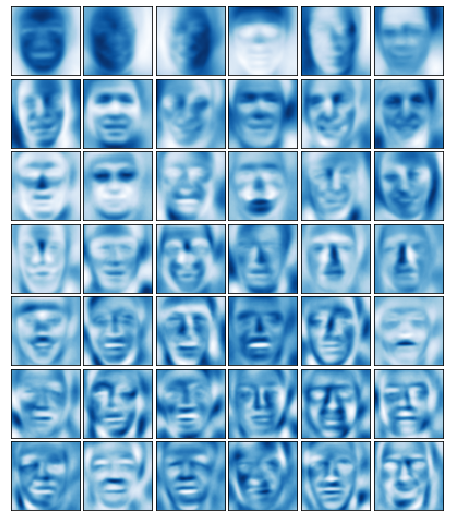

In [15]:
num_eigenfaces = 42
fig = plt.figure(figsize=(6, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(num_eigenfaces):
    ax = fig.add_subplot(7, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.reshape(pipeline.named_steps['pca'].components_[i, :], face_size), cmap=plt.cm.Blues_r,
              interpolation='nearest')
plt.show()

### Proyección y reconstrucción de los eigenfaces

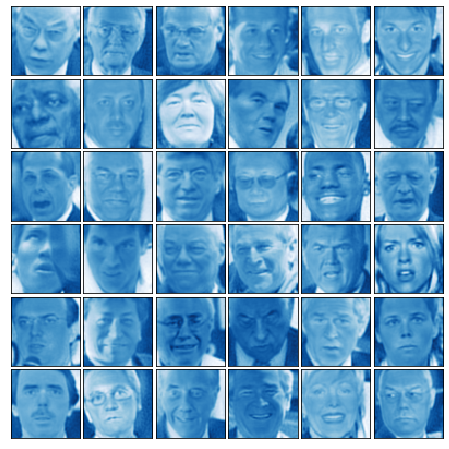

In [16]:
faces_processing_inv = pipeline.named_steps['pca'].inverse_transform(faces_processing)
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
j = 1
np.random.seed(413)
for i in np.random.choice(range(faces.shape[0]), 36):
    ax = fig.add_subplot(6, 6, j, xticks=[], yticks=[])
    ax.imshow(mean_face + sd_face * np.reshape(faces_processing_inv, (-1, face_size[0], face_size[1]))[i, :],
              cmap=plt.cm.Blues_r, interpolation='nearest')
    j += 1
plt.show()

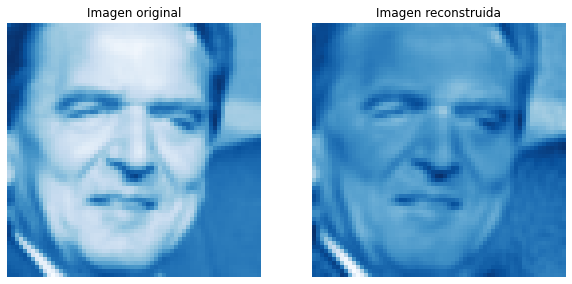

In [17]:
original_face = np.reshape(faces[0, :], face_size)
reconstructed_face = np.reshape(faces_processing[0, :]@pipeline.named_steps['pca'].components_,
                                face_size)
reconstructed_face = mean_face + sd_face * reconstructed_face
plt.figure(figsize=(10, 8))
plt.subplot(121)
plt.imshow(original_face, cmap=plt.cm.Blues_r, interpolation='nearest')
plt.axis('off')
plt.title('Imagen original')
plt.subplot(122)
plt.imshow(reconstructed_face, cmap=plt.cm.Blues_r, interpolation='nearest')
plt.axis('off')
plt.title('Imagen reconstruida')
plt.show()

In [19]:
image_count = 0
frames = []
def get_pca_img(num_components, face=0):
    pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=num_components))])
    faces_processing =  pipeline.fit_transform(faces)
    mean_face = np.reshape(pipeline.named_steps['scaling'].mean_, face_size)
    sd_face = np.reshape(pipeline.named_steps['scaling'].var_, face_size)
    reconstructed_face = np.reshape(faces_processing[face, :]@pipeline.named_steps['pca'].components_,
                                    face_size)
    reconstructed_face = mean_face + sd_face * reconstructed_face
    return reconstructed_face


# Reconstrucción de la primera imagen
for i in range(1024, 24 - 1, -10):
    # fig = plt.figure()
    # plt.axis('off')
    # plt.title('Imagen reconstruida')
    reconstructed_face = get_pca_img(num_components=i) # .astype(np.uint8)
    # img = plt.imshow(reconstructed_face, cmap=plt.cm.Blues_r, interpolation='nearest')
    plt.imsave(f'faces/0_{i}.png', reconstructed_face, cmap=plt.cm.Blues_r)
    # frames.append(reconstructed_face)

for i in range(24, 1024 + 1, 10):
    # fig = plt.figure()
    # plt.axis('off')
    # plt.title('Imagen reconstruida')
    reconstructed_face = get_pca_img(num_components=i, face=13) # .astype(np.uint8)
    # img = plt.imshow(reconstructed_face, cmap=plt.cm.Blues_r, interpolation='nearest')
    plt.imsave(f'faces/13_{i}.png', reconstructed_face, cmap=plt.cm.Blues_r)
    # frames.append(reconstructed_face)

In [ ]:
import glob
from PIL import Image

frames = []
imgs_0 = glob.glob('faces/0_*.png')
list.sort(imgs_0, key=lambda x: int(x.split('0_')[1].split('.png')[0]), reverse=True)
imgs_13 = glob.glob('faces/13_*.png')
list.sort(imgs_13, key=lambda x: int(x.split('13_')[1].split('.png')[0]))
imgs = imgs_0 + imgs_13

for img in imgs:
    frame = Image.open(img)
    frames.append(frame)

frames[0].save('image_reconstruction.gif', format='GIF', append_images=frames[1:],
               save_all=True, duration=100, loop=0)